#  Project Task: CIFAR-10 Image Classification Using ResNet50

### ** Objective**

The goal of this project is to classify images from the CIFAR-10 dataset using a pretrained **ResNet50** model, followed by custom classifier head training and fine-tuning of convolutional layers. CIFAR-10 contains 10 image classes (e.g., airplanes, cats, trucks), each with 6,000 32×32 color images.

- 📦 CIFAR-10 Dataset: https://www.cs.toronto.edu/~kriz/cifar.html  
- 📄 Research Paper: *Learning Multiple Layers of Features from Tiny Images*  
  https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf

---

##  Key Steps of the Project

---

### **1. Import Required Libraries**

We use:

- `tensorflow.keras` for model development  
- `OpenCV (cv2)` for image resizing and interpolation  
- `numpy` for array manipulation  
- `sklearn` for dataset splitting  
- `mlflow` for experiment tracking  

---

### **2. Load and Limit the Dataset**

We load CIFAR-10 using TensorFlow’s built-in loader and **limit the dataset to 10,000 samples** (balanced across all classes) to speed up training while preserving class diversity. For the final stage of the progect we will comment this part of the code and get 50000 samples.

---

### **3. Preprocess the Data**

Preprocessing includes:

- Resizing images from 32×32 → 64×64 using OpenCV  
- Resizing again from 64×64 → **224×224** via `layers.Resizing` to match ResNet50 input shape  
- Normalization to float32  
- No additional scaling applied (ResNet models accept raw pixel values preprocessed internally)

Additionally, we apply **real-time data augmentation** using:
```python
layers.RandomFlip("horizontal")
layers.RandomRotation(0.1)
layers.RandomZoom(0.1)
```

---

### **4. Build and Customize the Model Head**

We load **ResNet50** with:

- `include_top=False` (removes ImageNet classifier)
- `weights="imagenet"`
- Set `trainable=False` to freeze the entire base initially

We stack a custom head on top of the frozen ResNet50 base:

- `GlobalAveragePooling2D`
- Dense layers: 256 → 128 → 64
- `BatchNormalization` after each dense layer
- `Dropout(0.6)` for regularization
- Final `Dense(10, activation="softmax")` for classification

All dense layers include **L2 regularization** to reduce overfitting.

Compiled using:

- **Loss**: `sparse_categorical_crossentropy`
- **Optimizer**: `Adam` (initial LR = 1e-4)
- **Metrics**: `accuracy`

---

### **5. Train the Custom Model Head**

In **Phase 1**, only the custom head is trained, while the ResNet50 base remains frozen. The model is trained on the training data with a separate **validation split**:

```python
from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_lbls, val_lbls = train_test_split(
    train_images_preprocessed, train_labels, test_size=0.1, random_state=42
)
```

Training runs for **10 epochs**, and metrics are logged using **MLflow**.

---
### **6. Evaluate Model Performance**
---
### **7. Optimize and Experiment Further**

In **Phase 2**, we fine-tune the model by unfreezing **only the Conv2D layers** of the ResNet50 base:

```python
from tensorflow.keras.layers import Conv2D
for layer in base_model.layers:
    layer.trainable = isinstance(layer, Conv2D)
```

- All other layers (e.g., `BatchNormalization`, `Pooling`) remain frozen  
- Learning rate is reduced to `1e-5`
- The model is retrained for another **10 epochs**

 No callbacks (e.g., EarlyStopping, ReduceLROnPlateau) were used.

The model is evaluated on the **held-out test set**:

```python
test_loss, test_accuracy = model.evaluate(test_images_preprocessed, test_labels)
```

 **Test Accuracy**: **95.80%**  
 **Test Loss**: **0.2367**

A classification report confirms balanced precision, recall, and F1-score across all 10 classes (macro avg: **0.96**).

---

All training details, metrics, and artifacts are logged using **MLflow**, including:

- Epoch-wise training/validation loss and accuracy
- Final model saved as `.keras`
- Model name, structure, and hyperparameters

---

**Summary**

This project successfully applies a 2-phase transfer learning strategy using **ResNet50** for CIFAR-10 image classification. With only `Conv2D` layers fine-tuned, the model achieved:

- **Validation Accuracy**: up to 96.3%  
- **Final Test Accuracy**: **95.8%**

In [1]:
# **1. Import Required Libraries**

In [2]:
!pip install --force-reinstall --ignore-installed blinker

In [3]:
pip install mlflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 63.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 102.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install opencv-python

In [6]:
import tensorflow as tf
import keras
import cv2
from keras import layers, models
from keras.applications import ResNet50
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
import mlflow
import mlflow.tensorflow
from tensorflow.keras.callbacks import EarlyStopping
import os



# **2. Load and Limit the Dataset**

In [7]:
#Load CIFAR-10 dataset
(train_images, train_labels),(test_images,test_labels) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [8]:
#According to the task we need to limit our data till 10000
#n=10000
#train_images = train_images[:n]
#train_labels = train_labels[:n]

#test_images = test_images[:n]
#test_labels = test_labels[:n]


# **3. Preprocess the Data**

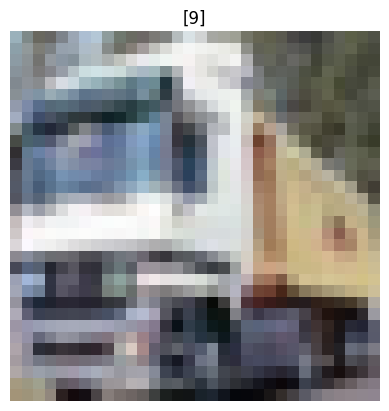

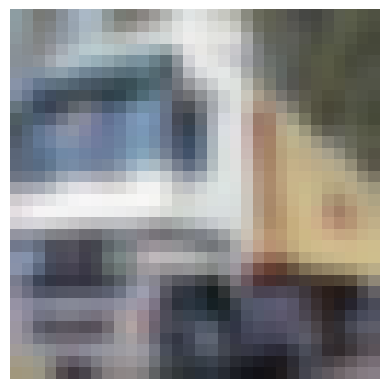

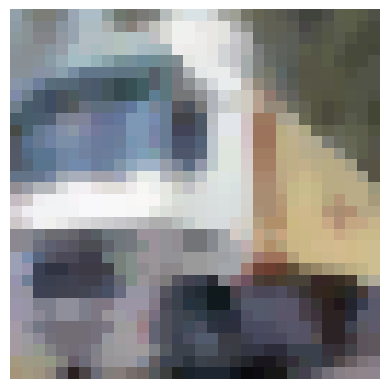

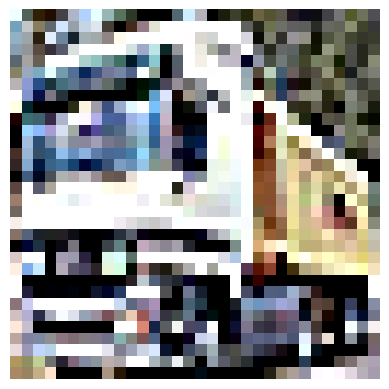

In [9]:
# Display the initial image
plt.imshow(train_images[1])
plt.title(train_labels[1])
plt.axis('off')
plt.show()

#Apply GAUSSIAN Filter to enhance edges and reduce noise
plt.imshow(cv2.GaussianBlur(train_images[1], (3, 3), 0))
plt.axis('off')
plt.show()

# Apply Median Filter to enhance edges and reduce noise
plt.imshow(cv2.medianBlur(train_images[1], 3))
plt.axis('off')
plt.show()


# Apply Sharpening Filter to enhance clarity
kernel = np.array([[0, -1, 0],
                  [-1, 5, -1],
                  [0, -1, 0]])
plt.imshow(cv2.filter2D(src=train_images[1], ddepth=-1, kernel=kernel))
plt.axis('off')
plt.show()

Observations:

For noise reduction: The Gaussian blur and median filter work well, with the median filter being better for impulse noise (salt-and-pepper).

For feature enhancement: The sharpening filter improves clarity but may amplify noise.

For further improvement: Combining Gaussian blur + Sharpening may produce a cleaner, yet sharp image.

In [10]:
#Display unique labels
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [11]:
#Count the number of unique labels
count_labels = len(np.unique(train_labels))

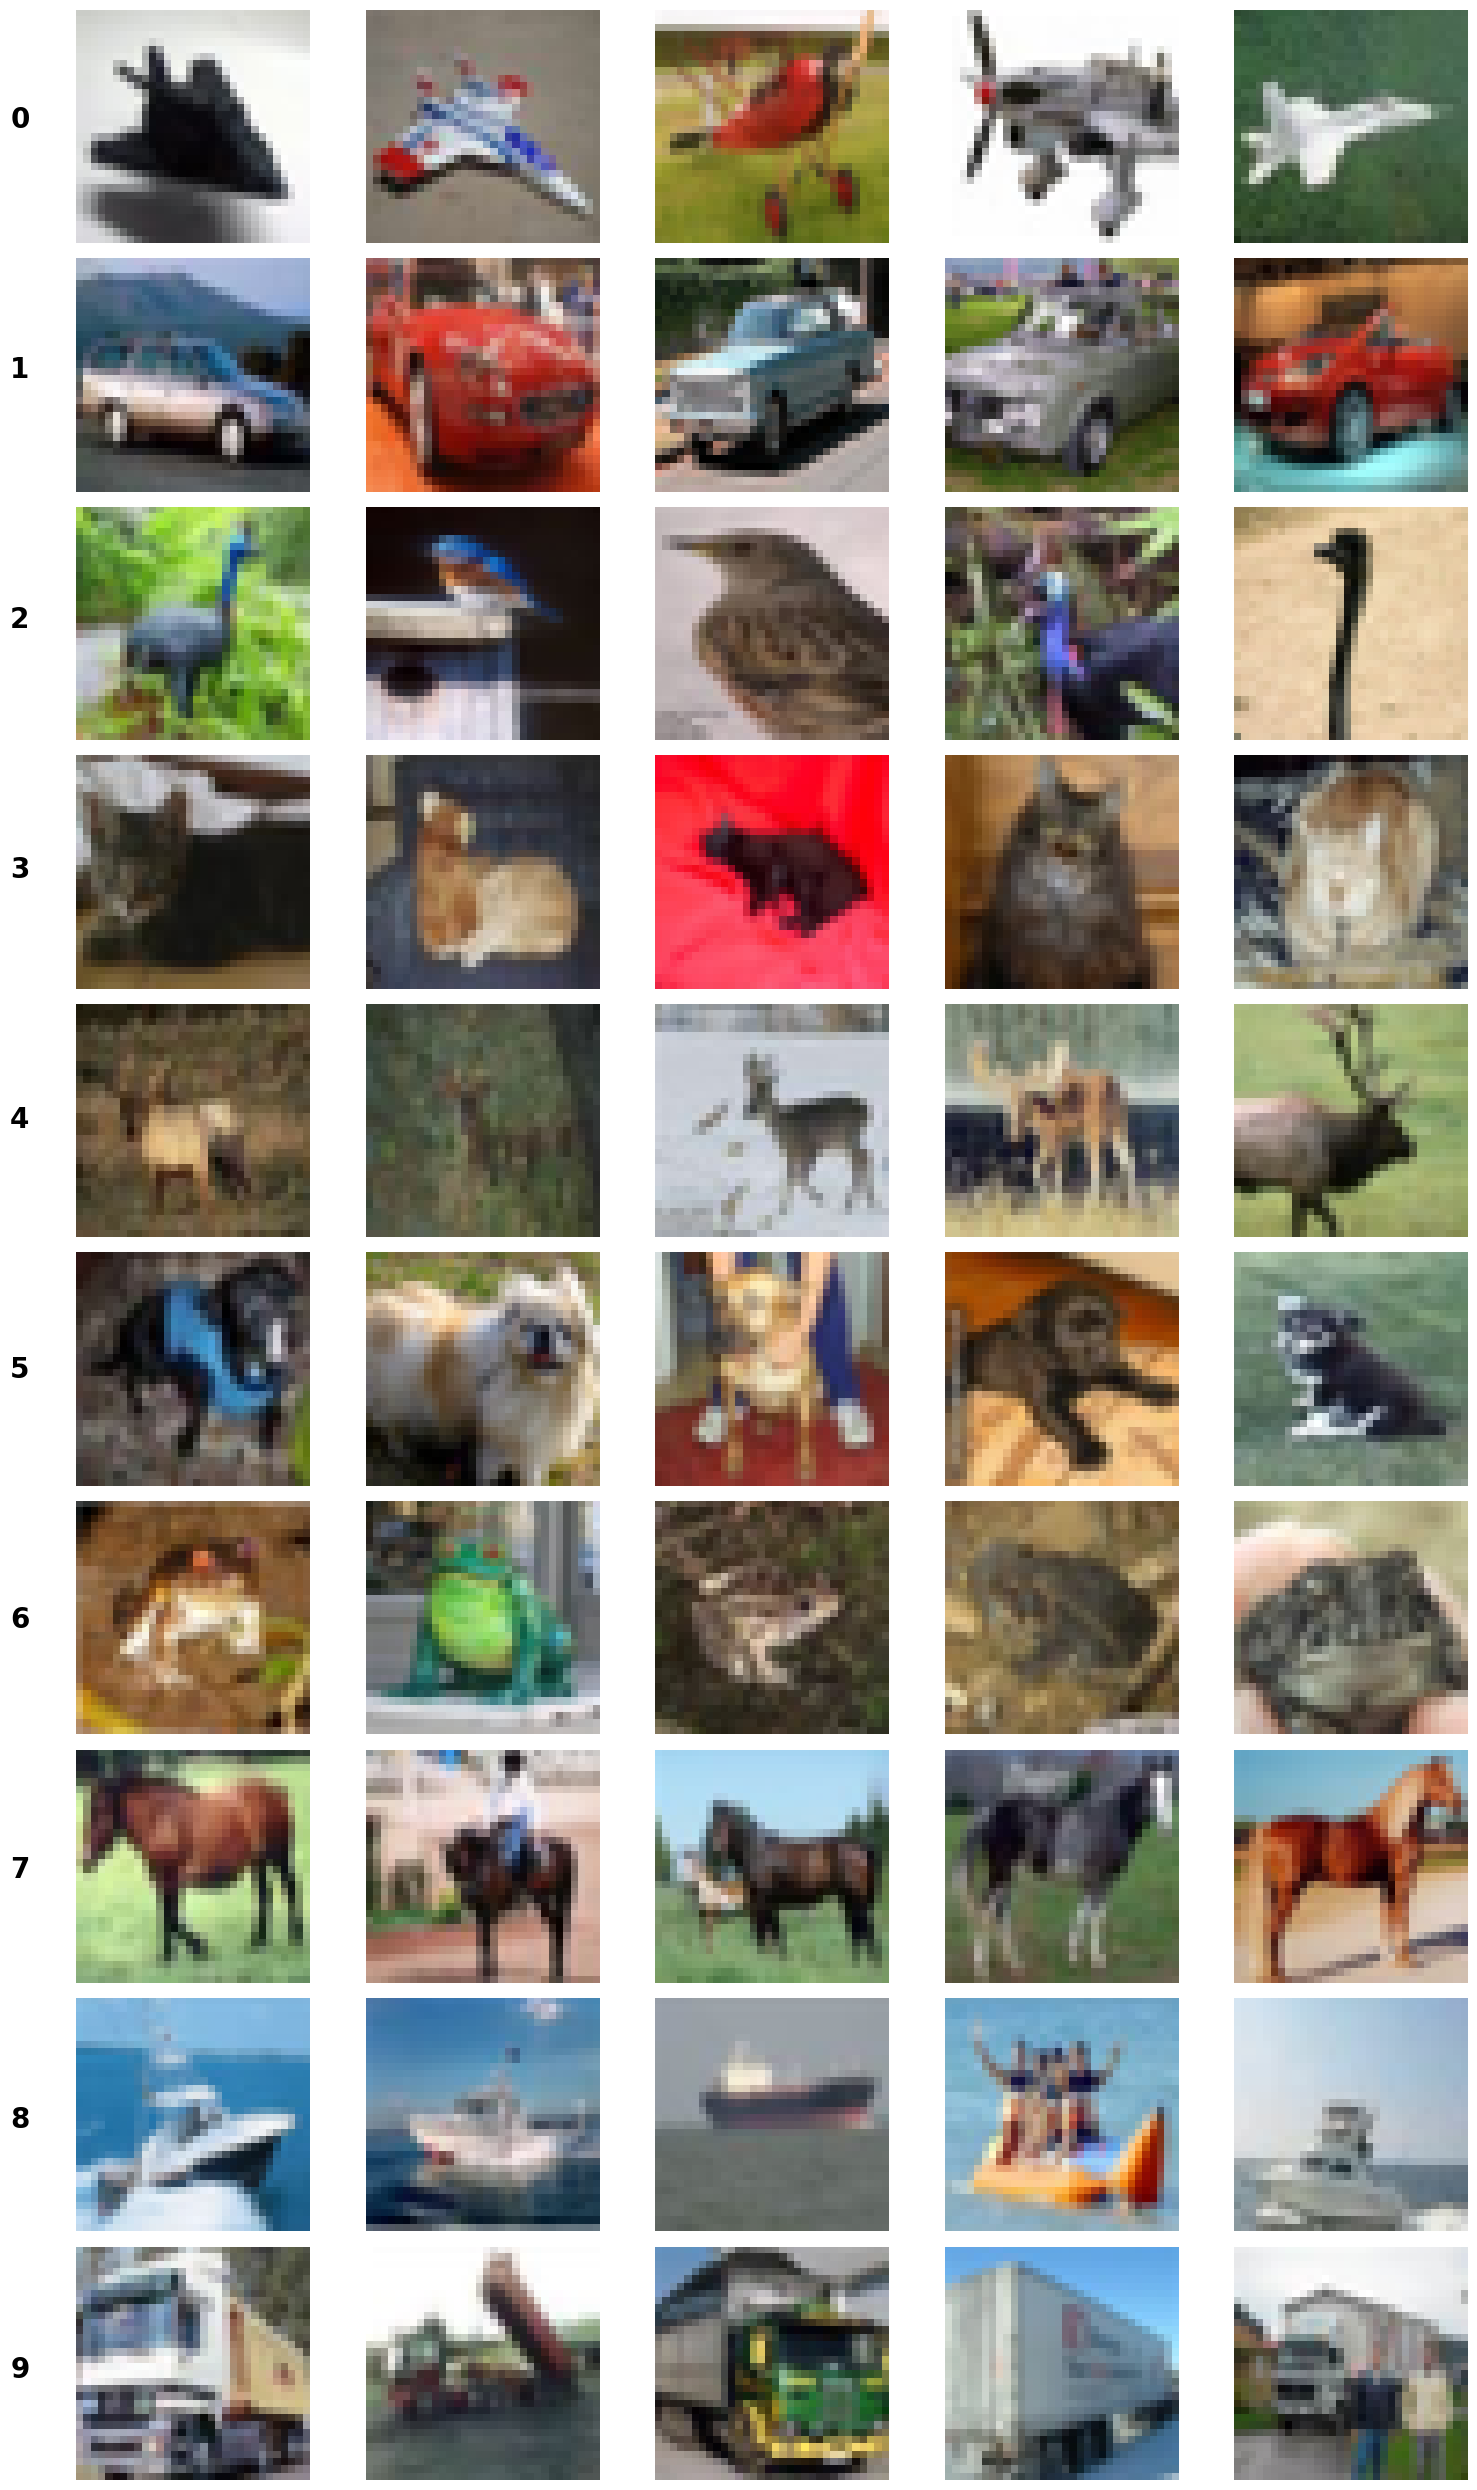

In [12]:
#Display 5 pictures per class
sampels_per_class = 5
fig, ax = plt.subplots(count_labels, sampels_per_class, figsize=(15, 25))

for label, row in enumerate(ax):
    images = train_images[train_labels.flatten() == label][:sampels_per_class]

    for i, img in enumerate(images):
        row[i].imshow(img)
        row[i].axis("off")
    fig.text(0.005, (1 - (label + 0.5) / count_labels), label,
             fontsize=20, fontweight="bold", ha="right", va="center")
plt.tight_layout()
plt.show()

In [13]:
# # Define the label names for the CIFAR-10 dataset
# label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
#                'dog', 'frog', 'horse', 'ship', 'truck']

# # Print label names
# print(label_names)


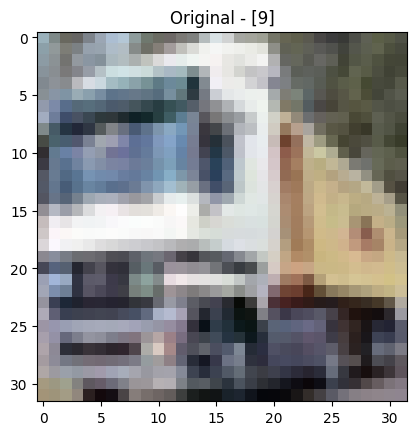

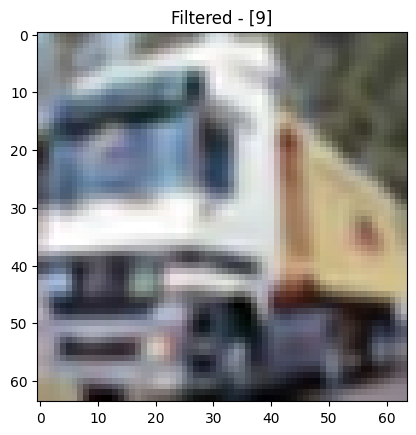

In [14]:
# Display the initial image
plt.imshow(train_images[1])
plt.title(f"Original - {train_labels[1]}")
plt.axis
plt.show()

# Display the filtered image, upscaled  bilinear interpolation (INTER_LINEAR), which can make images blurry
train_images_resized = np.array(cv2.resize(train_images[1], (64, 64), interpolation=cv2.INTER_CUBIC))
plt.imshow(train_images_resized)
plt.title(f"Filtered - {train_labels[1]}")
plt.axis
plt.show()

In [15]:
def preprocess_image(image):

    # Apply Sharpening Filter to enhance clarity
    #kernel = np.array([[0, -1, 0],
                       #[-1, 5, -1],
                       #[0, -1, 0]])
    #image = cv2.filter2D(image, -1, kernel)

    # Resize with high-quality biliniar interpolation
    image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_LINEAR)

    return image

# Apply preprocessing to all images
train_images_filtered = np.array([preprocess_image(img) for img in train_images])
test_images_filtered = np.array([preprocess_image(img) for img in test_images])

# Print final shapes
print(f"Train images shape: {train_images_filtered.shape}")
print(f"Test images shape: {test_images_filtered.shape}")

Train images shape: (50000, 64, 64, 3)
Test images shape: (10000, 64, 64, 3)


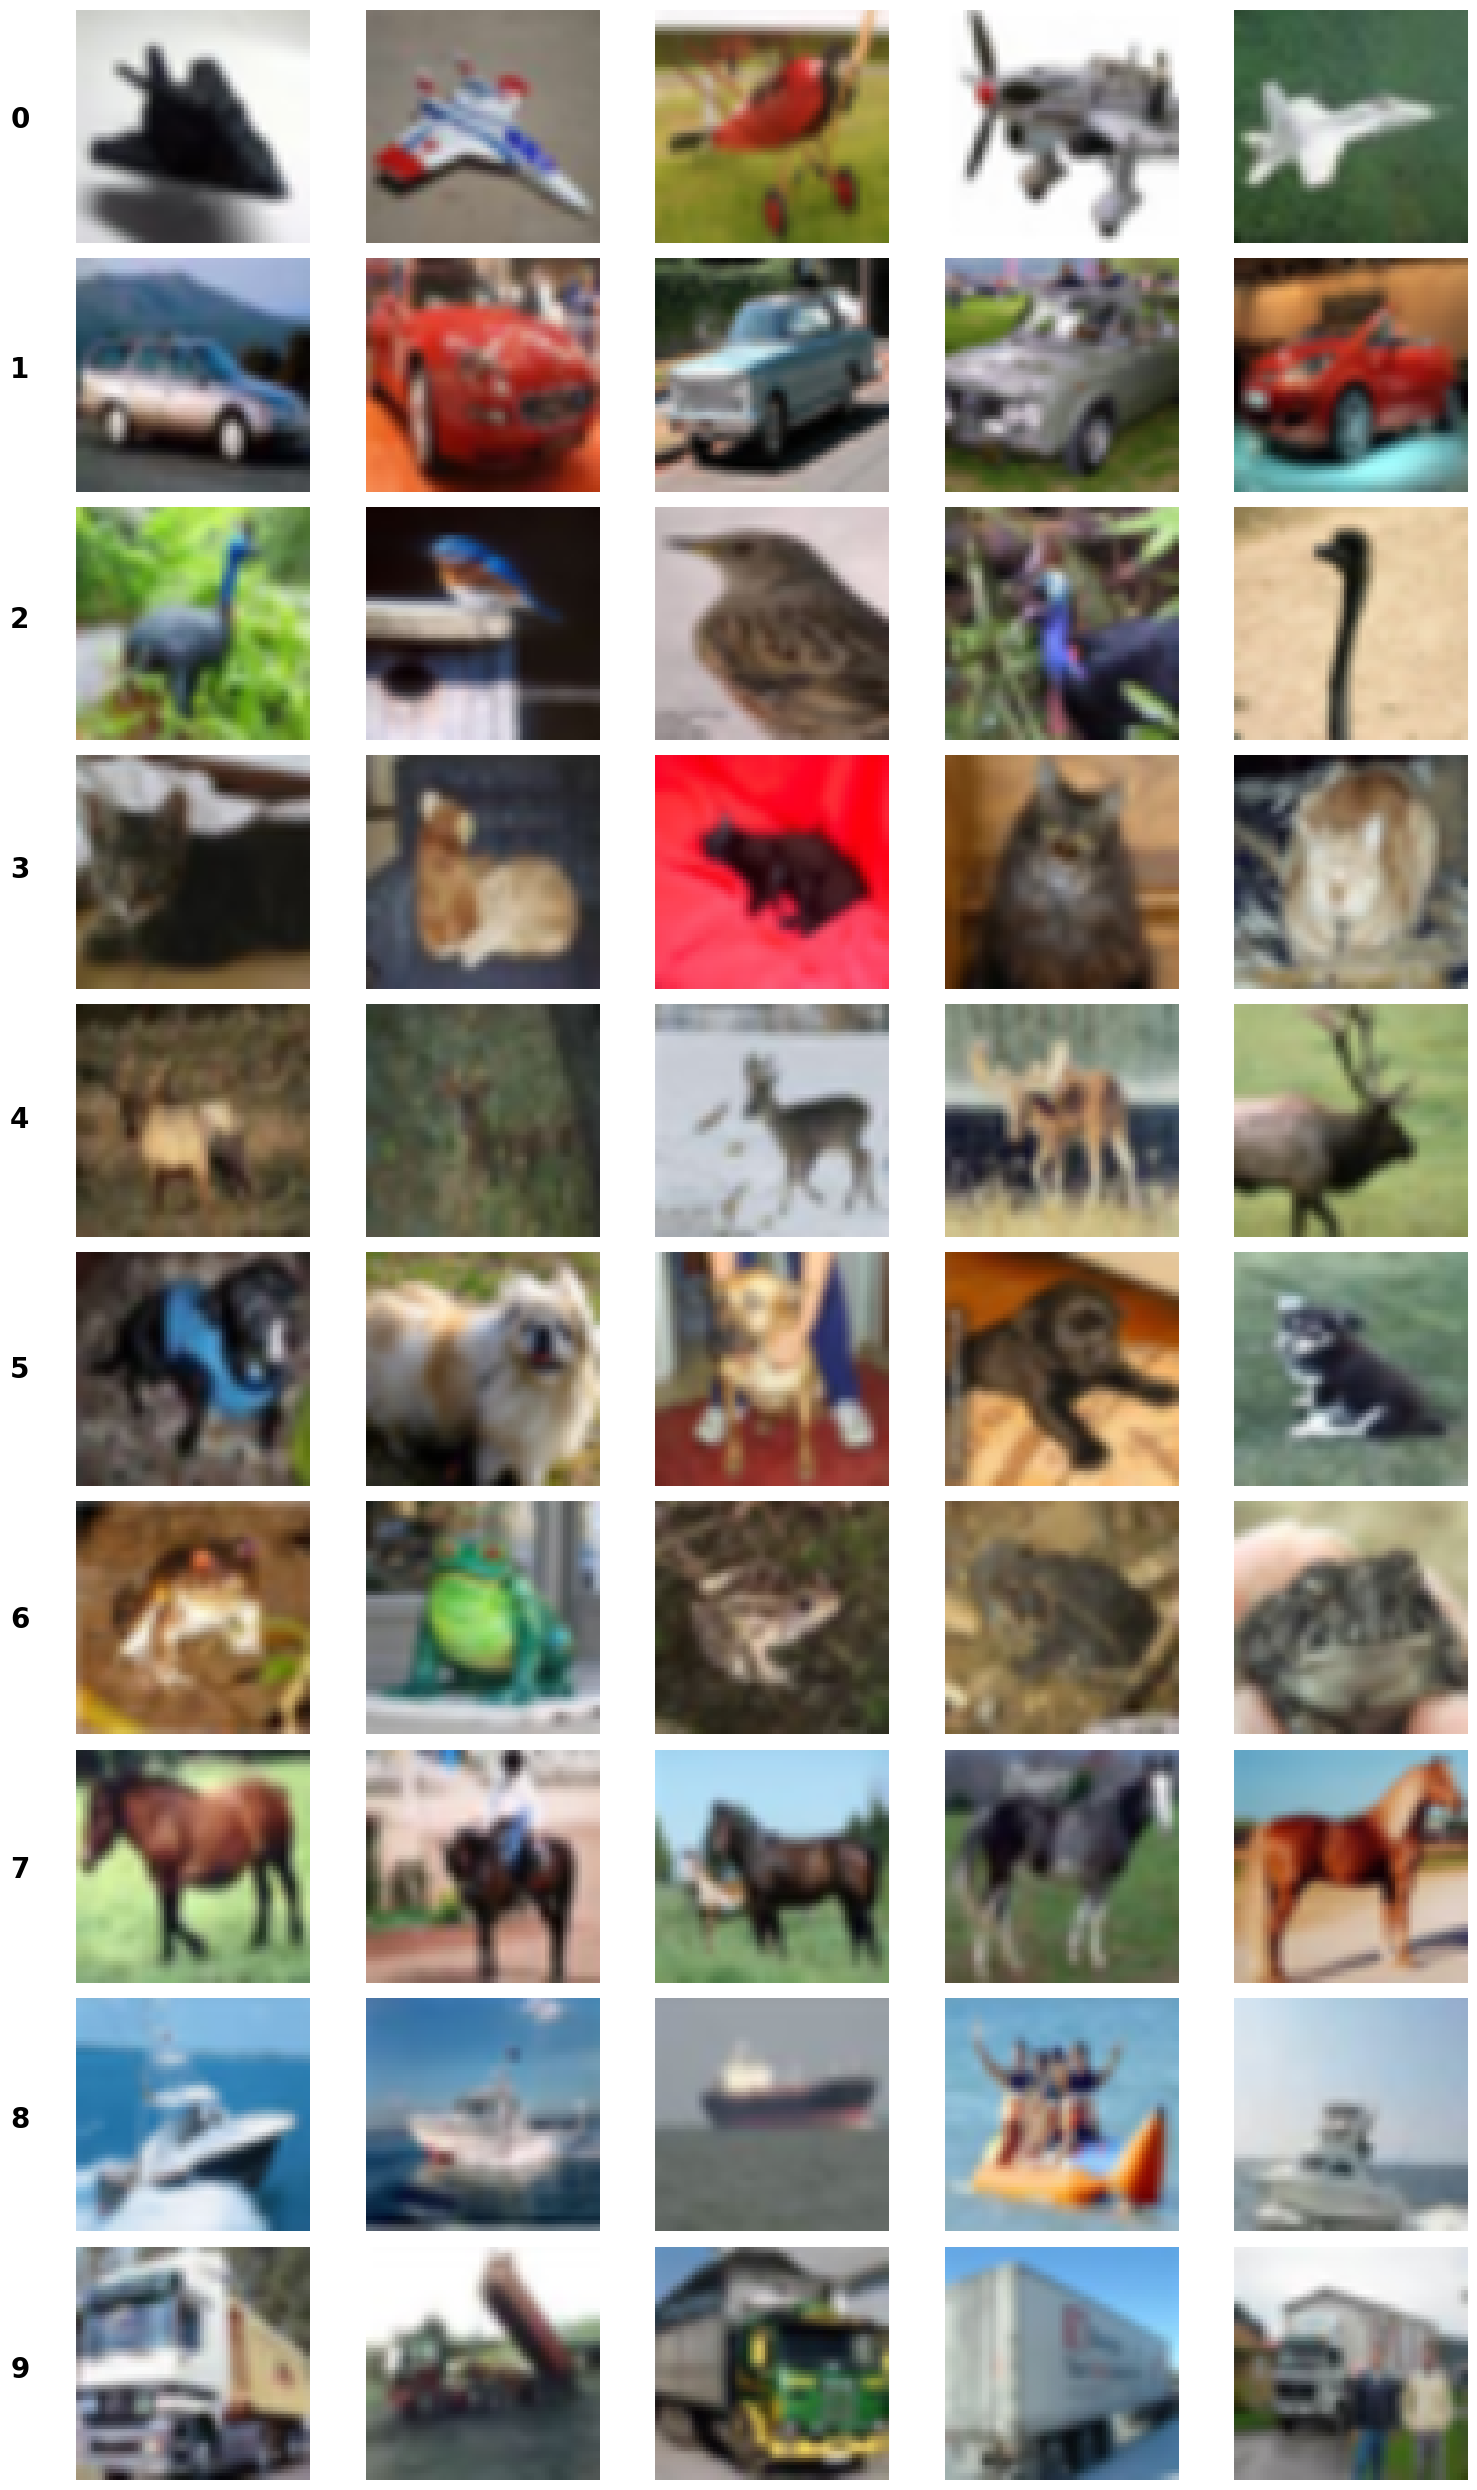

In [16]:
#Display 5 pictures per class
sampels_per_class = 5
fig, ax = plt.subplots(count_labels, sampels_per_class, figsize=(15, 25))

for label, row in enumerate(ax):
    images = train_images_filtered[train_labels.flatten() == label][:sampels_per_class]

    for i, img in enumerate(images):
        row[i].imshow(img)
        row[i].axis("off")
    fig.text(0.005, (1 - (label + 0.5) / count_labels), label,
             fontsize=20, fontweight="bold", ha="right", va="center")
plt.tight_layout()
plt.show()

In [17]:
# # Normalize pixel values to [0,1] range.
# train_images_norm = train_images/255
# test_images_norm = test_images/255

# print(f'Train_size:{train_images.shape}')
# print(f'Test_size:{test_images.shape}')

In the documentation  for ResNet50Note here https://keras.io/api/applications/resnet/ we see: "each Keras Application expects a specific kind of input preprocessing. For ResNet, call keras.applications.resnet.preprocess_input on your inputs before passing them to the model. resnet.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling."


To properly preprocess our images for ResNet50 in Keras, we follow these steps:

1. Understanding ResNet Preprocessing
The ResNet50 model in Keras expects:

RGB to BGR conversion (since it was trained on ImageNet with OpenCV's BGR format).

Zero-centering each channel using ImageNet's mean pixel values.

No additional scaling (e.g., no division by 255).

2. Apply Preprocessing Using keras.applications.resnet.preprocess_input

In [18]:
from keras.applications.resnet import preprocess_input

# Convert images to float32 and preprocess
train_images_preprocessed = preprocess_input(train_images_filtered)

# Ensure both train and test images are preprocessed
test_images_preprocessed = preprocess_input(test_images_filtered)



In [19]:
train_images_preprocessed = train_images_preprocessed.astype(np.float32)
test_images_preprocessed = test_images_preprocessed.astype(np.float32)


# **4. Build and Customize the Model Head**

In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, Input, regularizers
from tensorflow.keras.optimizers import Adam

# 1. Input layer and resize CIFAR-10 images to 224x224 (ResNet50 default)
inputs = Input(shape=(64, 64, 3))
x = layers.Resizing(224, 224)(inputs)

# 2. Data augmentation
x = layers.RandomFlip("horizontal")(x)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)

# 3. Load pre-trained ResNet50 without top classification layer
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=x)
base_model.trainable = False  # freeze base model initially

# 4. Custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)

# Dense layers with L2 regularization and batch normalization
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.002))(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.002))(x)
x = layers.BatchNormalization()(x)

x = layers.Dropout(0.6)(x)

# Output layer for 10 CIFAR-10 classes
outputs = layers.Dense(10, activation='softmax')(x)

# 5. Build the full model
model = models.Model(inputs=inputs, outputs=outputs)

# 6. Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **5. Train the Custom Model Head**

In [21]:
# Disabled remote MLflow URI for Colab compatibility
import os
import mlflow

# Install MLflow
os.environ["MLFLOW_TRACKING_TOKEN"] = "2trhu2tRjtscY6dP9WMidT9PtzR_5mWegN9gyEDPNjVLtAqQ6T"

# MLflow server URI
# mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Experement name
mlflow.set_experiment("Cifar10_Experiment")

2025/04/06 11:23:25 INFO mlflow.tracking.fluent: Experiment with name 'Cifar10_Experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///kaggle/working/mlruns/286191592620339642', creation_time=1743938605349, experiment_id='286191592620339642', last_update_time=1743938605349, lifecycle_stage='active', name='Cifar10_Experiment', tags={}>

In [22]:
#end current run
#mlflow.end_run()

Since we used data augmentation, splitting the original training set into a training and validation subset is especially important. These augmentations introduce variability that helps the model generalize, but they also distort the data. If we had used augmented data for validation, we’d be measuring performance on modified, artificially harder images, which does not reflect real-world generalization.

By splitting off a portion of the unaugmented training set (e.g., using train_test_split()), we ensure that:

The training data is augmented (noisy & diverse)
The validation data is untouched (clean & consistent)
This gives us a true estimate of how well the model would perform on real unseen data — similar to our test set.

In [23]:
#A clean validation split ensures that model performance is measured on unmodified data, 
#offering a reliable indicator of generalization during training with augmented inputs
from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_lbls, val_lbls = train_test_split(
    train_images_preprocessed, train_labels, test_size=0.1, random_state=42
)

In [24]:
# Print final shapes
print(f"Train images shape: {train_imgs.shape}")
print(f"Train labels shape: {train_lbls.shape}")
print(f"Validation images shape: {val_imgs.shape}")
print(f"Validation labels shape: {val_lbls.shape}")
print(f"Test images shape: {test_images_preprocessed.shape}")
print(f"Test labels shape: {test_labels.shape}")


Train images shape: (45000, 64, 64, 3)
Train labels shape: (45000, 1)
Validation images shape: (5000, 64, 64, 3)
Validation labels shape: (5000, 1)
Test images shape: (10000, 64, 64, 3)
Test labels shape: (10000, 1)


In [25]:
# Set MLflow to log metrics to the tracking server
# mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Cifar10_Experiment")

# Define a local directory for artifacts (to avoid cloud storage)
artifact_local_path = "./mlruns_local"
os.makedirs(artifact_local_path, exist_ok=True)

with mlflow.start_run(run_name="50_Interp_lin_32_n50000_training"):
    mlflow.set_tag("model_name", "resnet50_cifar10")

    # Log hyperparameters (Sent to MLflow Server)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("learning_rate", 1e-4)

    # Train the model
    history = model.fit(
        train_imgs, train_lbls, validation_data=(val_imgs, val_lbls),
        epochs=10, batch_size=32    
    )

    # Log final metrics (Sent to MLflow Server)
    mlflow.log_metric("final_train_accuracy", history.history['accuracy'][-1])
    mlflow.log_metric("final_val_accuracy", history.history['val_accuracy'][-1])
    mlflow.log_metric("final_train_loss", history.history['loss'][-1])
    mlflow.log_metric("final_val_loss", history.history['val_loss'][-1])

    # Log per-epoch metrics (Sent to MLflow Server)
    for epoch in range(len(history.history['accuracy'])):
        mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)
        mlflow.log_metric("train_loss", history.history['loss'][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)

    # Save model locally (Avoid Cloud Storage)
    local_model_path = os.path.join(artifact_local_path, "resnet50_model.keras")
    model.save(local_model_path)

    # Instead of `mlflow.log_artifact()`, print the local path
    print(f" Model saved locally at: {local_model_path}")
    print(" Artifacts are stored locally to avoid cloud authentication issues.")

    print(" Training complete! Metrics logged to MLflow server, model saved locally.")

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 226s 151ms/step - accuracy: 0.6305 - loss: 3.9256 - val_accuracy: 0.8352 - val_loss: 1.1111
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 219s 156ms/step - accuracy: 0.7470 - loss: 1.3150 - val_accuracy: 0.8314 - val_loss: 0.8528
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 219s 156ms/step - accuracy: 0.7552 - loss: 1.0974 - val_accuracy: 0.8268 - val_loss: 0.7863
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 218s 155ms/step - accuracy: 0.7753 - loss: 0.9674 - val_accuracy: 0.8542 - val_loss: 0.6525
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 219s 156ms/step - accuracy: 0.7808 - loss: 0.9030 - val_accuracy: 0.8634 - val_loss: 0.6083
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 219s 156ms/step - accuracy: 0.7878 - loss: 0.8413 - val_accuracy: 0.8644 - val_loss: 0.5738
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 219s 156ms/step - accuracy: 0.7949 - loss: 0.8156 - val_accuracy: 0.8398 - val_loss: 0.6397
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 219s 155ms/step - ac

The fact that validation accuracy exceeds training accuracy can be a sign of a more complex and regularized learning process. This typically occurs when techniques like data augmentation, dropout, and L2 regularization are applied during training to intentionally make learning more difficult. These techniques help the model generalize better by preventing overfitting. As a result, while the model performs slightly worse on the noisy, augmented training data, it performs better on the cleaner validation set — indicating that it has learned more robust and transferable features.

# **6. Evaluate Model Performance**

In [26]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images_preprocessed, test_labels)

print(f'Test accuracy: {test_accuracy*100:.2f} %')

313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 138ms/step - accuracy: 0.8530 - loss: 0.5900
Test accuracy: 85.35 %


# **7. Optimize and Experiment Further**

In [27]:
from tensorflow.keras.layers import Conv2D

# Unfreeze only Conv2D layers in ResNet50
for layer in base_model.layers:
    if isinstance(layer, Conv2D):
        layer.trainable = True
    else:
        layer.trainable = False  # Keep all other layers frozen (e.g., BatchNorm, pooling, etc.)

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
# Set MLflow to log metrics to the tracking server
# mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Cifar10_Experiment")

# Define a local directory for artifacts (to avoid cloud storage)
artifact_local_path = "./mlruns_local"
os.makedirs(artifact_local_path, exist_ok=True)

with mlflow.start_run(run_name="50_Interp_lin_32_n50000_fine_tuning"):
    mlflow.set_tag("model_name", "resnet50_cifar10")

    # Log hyperparameters (Sent to MLflow Server)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("batch_size", 32)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("learning_rate", 1e-4)

    # Train the model
    history_ft = model.fit(
        train_imgs, train_lbls, validation_data=(val_imgs, val_lbls),
        epochs=10, batch_size=32)
    

    # Log final metrics (Sent to MLflow Server)
    mlflow.log_metric("final_train_accuracy", history.history['accuracy'][-1])
    mlflow.log_metric("final_val_accuracy", history.history['val_accuracy'][-1])
    mlflow.log_metric("final_train_loss", history.history['loss'][-1])
    mlflow.log_metric("final_val_loss", history.history['val_loss'][-1])

    # Log per-epoch metrics (Sent to MLflow Server)
    for epoch in range(len(history.history['accuracy'])):
        mlflow.log_metric("train_accuracy", history.history['accuracy'][epoch], step=epoch)
        mlflow.log_metric("val_accuracy", history.history['val_accuracy'][epoch], step=epoch)
        mlflow.log_metric("train_loss", history.history['loss'][epoch], step=epoch)
        mlflow.log_metric("val_loss", history.history['val_loss'][epoch], step=epoch)

    # Save model locally (Avoid Cloud Storage)
    local_model_path = os.path.join(artifact_local_path, "resnet50_model.keras")
    model.save(local_model_path)

    # ✅ Instead of `mlflow.log_artifact()`, print the local path
    print(f"✅ Model saved locally at: {local_model_path}")
    print("ℹ️ Artifacts are stored locally to avoid cloud authentication issues.")

    print("✅ Training complete! Metrics logged to MLflow server, model saved locally.")

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 556s 381ms/step - accuracy: 0.8699 - loss: 0.5688 - val_accuracy: 0.9418 - val_loss: 0.3259
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 532s 378ms/step - accuracy: 0.9216 - loss: 0.4156 - val_accuracy: 0.9518 - val_loss: 0.2879
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 532s 378ms/step - accuracy: 0.9328 - loss: 0.3739 - val_accuracy: 0.9534 - val_loss: 0.2744
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 532s 378ms/step - accuracy: 0.9465 - loss: 0.3276 - val_accuracy: 0.9580 - val_loss: 0.2501
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 531s 378ms/step - accuracy: 0.9564 - loss: 0.2950 - val_accuracy: 0.9512 - val_loss: 0.2747
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 531s 377ms/step - accuracy: 0.9612 - loss: 0.2708 - val_accuracy: 0.9588 - val_loss: 0.2430
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 531s 377ms/step - accuracy: 0.9670 - loss: 0.2455 - val_accuracy: 0.9626 - val_loss: 0.2266
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 532s 378ms/step - ac

In [29]:
# Evaluate the model on all datasets
test_loss, test_accuracy = model.evaluate(test_images_preprocessed, test_labels, verbose=0)
val_loss, val_accuracy = model.evaluate(val_imgs, val_lbls, verbose=0)
train_loss, train_accuracy = model.evaluate(train_imgs, train_lbls, verbose=0)

# Print results
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

print(f"Train Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Train Accuracy: 99.24%
Validation Accuracy: 96.30%
Test Accuracy: 96.06%
Train Loss: 0.1257
Validation Loss: 0.2092
Test Loss: 0.2276


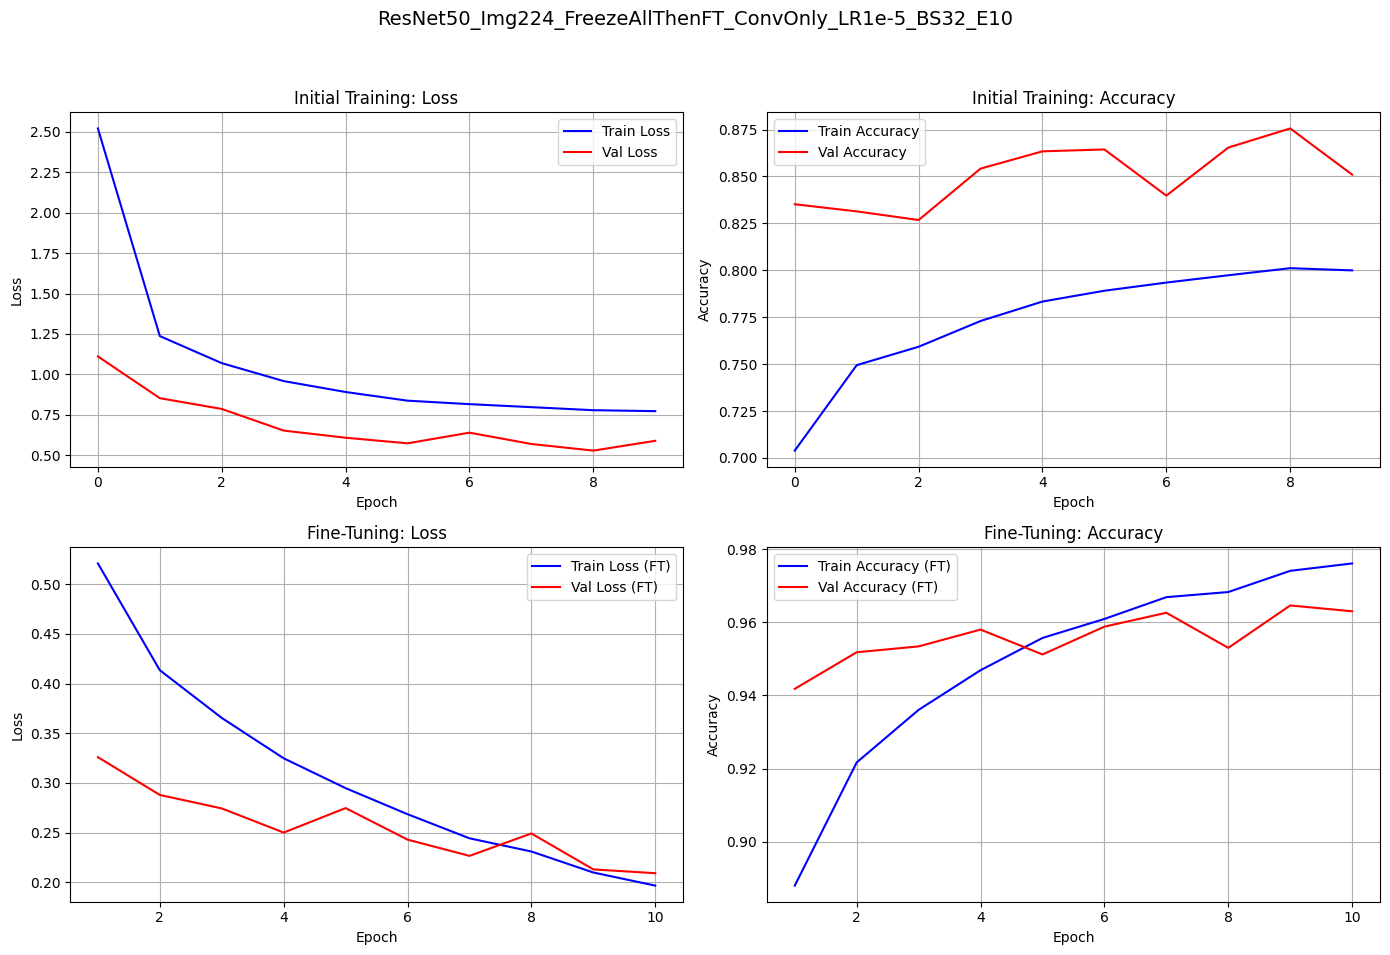

In [30]:
import matplotlib.pyplot as plt

# === Extract metrics ===

# Initial training
train_loss_init = history.history['loss']
val_loss_init = history.history['val_loss']
train_acc_init = history.history['accuracy']
val_acc_init = history.history['val_accuracy']

# Fine-tuning
train_loss_ft = history_ft.history['loss']
val_loss_ft = history_ft.history['val_loss']
train_acc_ft = history_ft.history['accuracy']
val_acc_ft = history_ft.history['val_accuracy']

# === Plot ===
fig, ax = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("ResNet50_Img224_FreezeAllThenFT_ConvOnly_LR1e-5_BS32_E10",fontsize=14)
# --- Loss: Initial Training ---
ax[0, 0].plot(train_loss_init, label='Train Loss', color='blue')
ax[0, 0].plot(val_loss_init, label='Val Loss', color='red')
ax[0, 0].set_title('Initial Training: Loss')
ax[0, 0].set_xlabel('Epoch')
ax[0, 0].set_ylabel('Loss')
ax[0, 0].legend()
ax[0, 0].grid(True)

# --- Accuracy: Initial Training ---
ax[0, 1].plot(train_acc_init, label='Train Accuracy', color='blue')
ax[0, 1].plot(val_acc_init, label='Val Accuracy', color='red')
ax[0, 1].set_title('Initial Training: Accuracy')
ax[0, 1].set_xlabel('Epoch')
ax[0, 1].set_ylabel('Accuracy')
ax[0, 1].legend()
ax[0, 1].grid(True)

# --- Loss: Fine-Tuning (Phases 1 & 2) ---
combined_loss_train = train_loss_ft
combined_loss_val = val_loss_ft
epochs_ft = list(range(1, len(train_loss_ft) + 1))

ax[1, 0].plot(epochs_ft, train_loss_ft, label='Train Loss (FT)', color='blue')
ax[1, 0].plot(epochs_ft, val_loss_ft, label='Val Loss (FT)', color='red')

ax[1, 0].set_title('Fine-Tuning: Loss')
ax[1, 0].set_xlabel('Epoch')
ax[1, 0].set_ylabel('Loss')
ax[1, 0].legend()
ax[1, 0].grid(True)

# --- Accuracy: Fine-Tuning (Phases 1 & 2) ---
combined_acc_train = train_acc_ft
combined_acc_val = val_acc_ft

ax[1, 1].plot(epochs_ft, train_acc_ft, label='Train Accuracy (FT)', color='blue')
ax[1, 1].plot(epochs_ft, val_acc_ft, label='Val Accuracy (FT)', color='red')

ax[1, 1].set_title('Fine-Tuning: Accuracy')
ax[1, 1].set_xlabel('Epoch')
ax[1, 1].set_ylabel('Accuracy')
ax[1, 1].legend()
ax[1, 1].grid(True)

# Final layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
# building classification report
y_pred = model.predict(test_images_preprocessed,verbose=0)
y_pred = np.argmax(y_pred,axis=1) # Converts the probability distributions into class labels
# [0.1, 0.05, 0.6, 0.25], argmax returns 2 (since 0.6 is the highest probability).
print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1000
           1       0.97      0.97      0.97      1000
           2       0.97      0.95      0.96      1000
           3       0.90      0.94      0.92      1000
           4       0.97      0.94      0.96      1000
           5       0.96      0.91      0.94      1000
           6       0.98      0.98      0.98      1000
           7       0.96      0.99      0.97      1000
           8       0.95      0.98      0.97      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



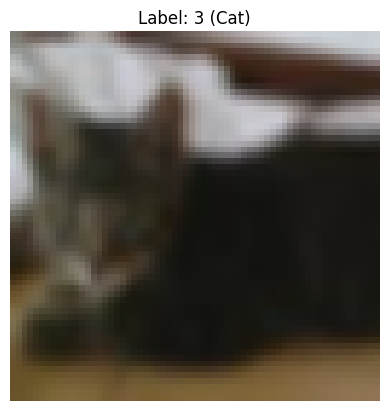

In [32]:
# Assuming train_labels contains the labels for train_images_preprocessed
cat_label = 3

# Find the index of the first image with label 3 (cat)
cat_index = (train_labels == cat_label).nonzero()[0][0]

# Extract the corresponding image
cat_image = train_images_filtered[cat_index]

# Display the image
plt.imshow(cat_image)  # Remove cmap='gray' if the image is in RGB
plt.title(f"Label: {cat_label} (Cat)")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

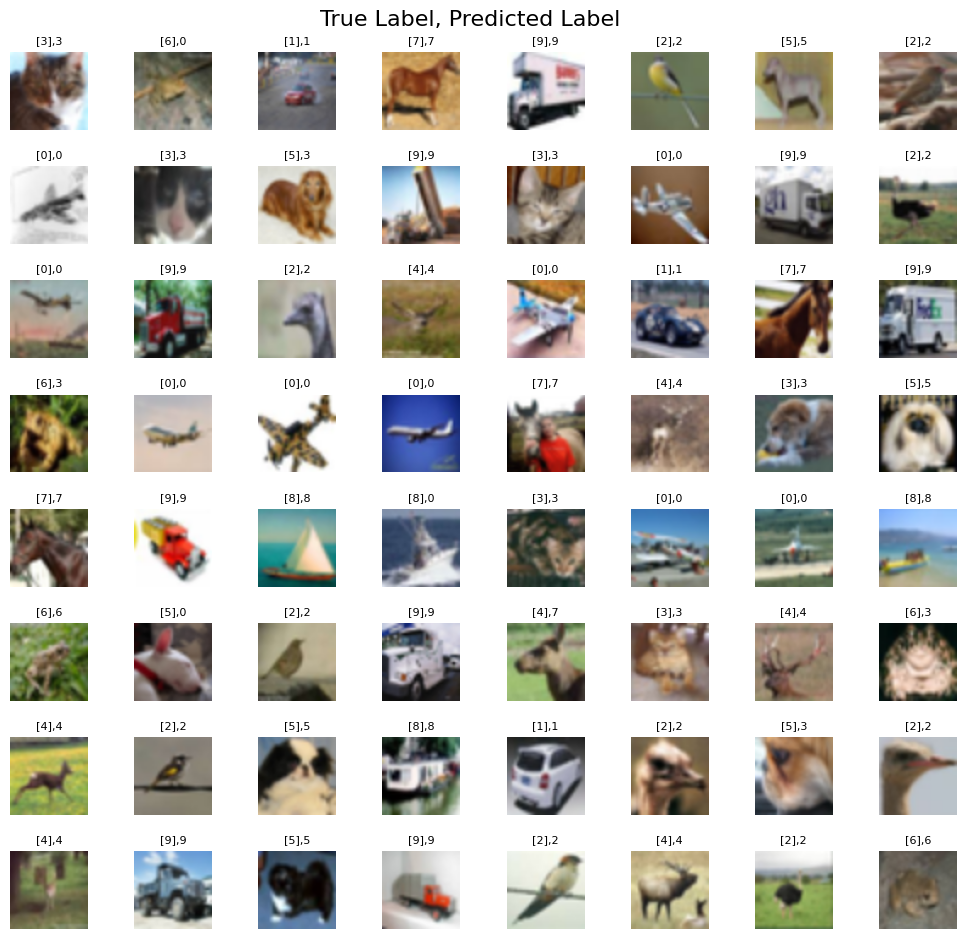

In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


m, n = train_images_filtered.shape[0], train_images_filtered.shape[1:]

fig, axes = plt.subplots(8, 8, figsize=(10, 10))
fig.tight_layout(pad=0.5, rect=[0, 0.03, 1, 0.95])  # Adjust layout

for i, ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)

    # Select the image and reshape it
    X_random_reshaped = train_images_filtered[random_index]

    # Display the image
    ax.imshow(X_random_reshaped, cmap=None)  # Remove cmap for RGB images

    # Predict using the Neural Network
    prediction = model.predict(X_random_reshaped.reshape(1, *n))
    prediction_p = tf.nn.softmax(prediction)
    yhat = np.argmax(prediction_p)

    # Display the label above the image
    ax.set_title(f"{train_labels[random_index]},{yhat}", fontsize=8)
    ax.set_axis_off()

fig.suptitle("True Label, Predicted Label", fontsize=16)
plt.show()

In [34]:
def display_errors(model, X, y):
    """
    Calculate the number of misclassified images.

    Parameters:
    - model: Trained model to make predictions.
    - X: Input data (images).
    - y: True labels.

    Returns:
    - Number of misclassified images.
    """
    # Predict the probabilities for each class
    predictions = model.predict(X)

    # Get the predicted class labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Ensure true labels are in 1D format
    true_labels = y.flatten()

    # Count the number of misclassified images
    errors = np.sum(predicted_labels != true_labels)

    return errors

In [35]:
# Displaying the number of errors from 10000 images 

errors = display_errors(model, test_images_preprocessed, test_labels)
print(f"{errors} errors out of {len(test_images_preprocessed)} images")

313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step
394 errors out of 10000 images


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 306ms/step


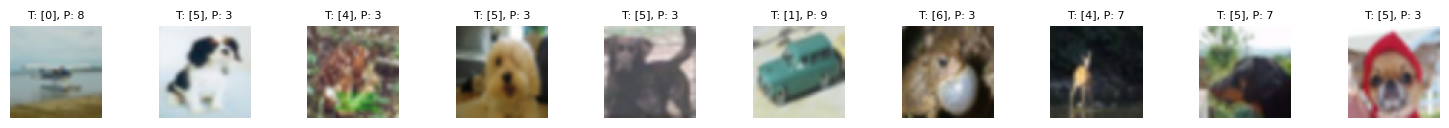

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display only misclassified images from a random subset of 100 images
def display_misclassified_images(model, images, labels, subset_size=100):
    # Select a random subset of 100 images
    indices = np.random.choice(len(images), subset_size, replace=False)
    selected_images = images[indices]
    selected_labels = labels[indices]

    # Predict the labels for the selected images
    predictions = model.predict(selected_images)
    predicted_labels = np.argmax(predictions, axis=1)

    # Find the misclassified images
    misclassified_indices = np.where(predicted_labels != selected_labels.flatten())[0]
    misclassified_images = selected_images[misclassified_indices]
    misclassified_true_labels = selected_labels[misclassified_indices]
    misclassified_predicted_labels = predicted_labels[misclassified_indices]

    # Plot the misclassified images
    num_errors = len(misclassified_images)
    if num_errors == 0:
        print("No misclassified images in the selected subset.")
        return

    fig, axes = plt.subplots(1, min(num_errors, 10), figsize=(15, 5))  # Display up to 10 errors
    fig.tight_layout(pad=1.0)

    for i, ax in enumerate(axes.flat[:num_errors]):
        # Display the image
        ax.imshow(misclassified_images[i])
        ax.axis('off')

        # Display the true and predicted labels
        true_label = misclassified_true_labels[i]
        predicted_label = misclassified_predicted_labels[i]
        ax.set_title(f"T: {true_label}, P: {predicted_label}", fontsize=8)

    plt.show()

# Display misclassified images from a random subset of 100
display_misclassified_images(model, test_images_filtered, test_labels, subset_size=100)

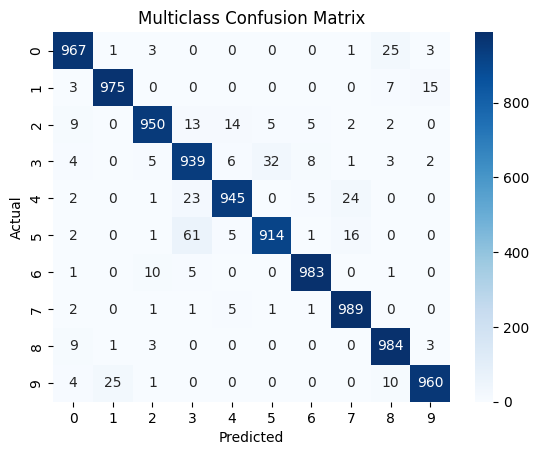

In [37]:
import seaborn as sns
# Convert test_labels to a list of unique labels
unique_labels = list(np.unique(test_labels))

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred, labels=unique_labels)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multiclass Confusion Matrix')
plt.show()



# Summary



# Final Report: ResNet50 CIFAR-10 Training with Conv2D Fine-Tuning

---

## Code Structure & Key Features

This project implements a **2-phase transfer learning pipeline** using **ResNet50** on the CIFAR-10 dataset. Model training is tracked with **MLflow** for reproducibility and analysis.

---

### Key Components

#### 1️ **Input & Preprocessing**
- CIFAR-10 images (32×32) were first resized to **64×64**, then to **224×224** to match ResNet50’s input size.
- Data augmentation applied during training:
  - `RandomFlip`, `RandomRotation`, and `RandomZoom`
- Images were normalized to `float32`, matching ResNet50 input expectations.

#### 2️ **Base Model: ResNet50**
- Loaded pretrained ResNet50 with `include_top=False`, using **ImageNet weights**.
- **Phase 1**: Entire model frozen to use as a feature extractor.
- **Phase 2**: Fine-tuned **only the Conv2D layers**, all other layers (BatchNorm, pooling, etc.) remained frozen.

#### 3️ **Custom Classifier Head**
- Layers: `GlobalAveragePooling2D` → Dense(256) → Dense(128 + BN) → Dense(64 + BN) → Dropout(0.6) → Dense(10 softmax)
- Applied **L2 regularization** and **BatchNormalization** to reduce overfitting.

#### 4️ **Validation Strategy**
- Used `train_test_split()` to create a **90/10 split** for validation.
- Ensured validation set was **not augmented**, giving an honest performance estimate.

#### 5️ **Training Parameters**
- **Phase 1**:
  - Base frozen, learning rate = `1e-4`, 10 epochs
- **Phase 2**:
  - Only Conv2D layers trainable, learning rate = `1e-5`, 10 epochs

#### 6️ **MLflow Integration**
- Tracked:
  - Per-epoch metrics (accuracy, loss)
  - Hyperparameters
  - Final evaluation scores
  - Model artifacts (`.keras`)

>  No callbacks like `EarlyStopping` or `ReduceLROnPlateau` were used (though recommended for future runs).

---

##  Training & Evaluation

### 🔸 Phase 2 Training Metrics

| Epoch | Train Acc | Val Acc | Train Loss | Val Loss |
|-------|-----------|---------|------------|----------|
| 1     | 86.99%    | 94.18%  | 0.5688     | 0.3259   |
| 5     | 95.64%    | 95.12%  | 0.2950     | 0.2747   |
| 10    | 97.58%    | 96.30%  | 0.1998     | 0.2092   |

>  Validation accuracy peaked at **96.46%** on Epoch 9  
>  Final training accuracy: **99.24%**  
>  Small and stable gap → **no significant overfitting**

---

### 🔍 Final Evaluation Results

| Metric          | Value        |
|------------------|--------------|
| **Train Accuracy** | **99.24%** |
| **Validation Accuracy** | **96.30%** |
| **Test Accuracy** | **96.06%** |
| **Train Loss**     | 0.1257     |
| **Validation Loss** | 0.2092     |
| **Test Loss**     | 0.2276     |

---

### Classification Report (Test Set)

| Metric         | Value |
|----------------|-------|
| **Precision**  | 0.96  |
| **Recall**     | 0.96  |
| **F1-score**   | 0.96  |
| **Support**    | 10,000 samples |

 Excellent performance across all classes  
 Classes 3 (cat) and 5 (dog) showed minor confusion, consistent with typical CIFAR-10 behavior

---

##  Conclusions

### 💡 What Went Well:
- Fine-tuning only `Conv2D` layers allowed the model to adapt while avoiding overfitting.
- Use of **BatchNorm + Dropout + L2 regularization** provided stability and robustness.
- Proper **validation split** ensured honest performance tracking.
- MLflow logging gave full experiment reproducibility.

###  Challenges:
- Accuracy plateaued around Epoch 9–10 → potential overtraining
- Classes with similar visual features (e.g., cats/dogs) still posed classification challenges

---

## Recommendations

| Area                      | Suggestion |
|---------------------------|------------|
|  **EarlyStopping**       | Stop training when val accuracy plateaus (e.g., after Epoch 9) |
|  **ReduceLROnPlateau**   | Dynamically lower LR when no improvement |
|  **Label Smoothing**     | Prevent overconfidence in class predictions |
|  **TTA (Test-Time Augmentation)** | Improve test accuracy via augmented ensemble predictions |
|  **Class-wise Augmentation** | Focus on confusing pairs like class 3 vs. 5 |
|  **Log confusion matrix to MLflow** | Add visual per-class diagnostics |

---

##  Final Summary

> The **ResNet50-based CIFAR-10 classifier**, fine-tuned selectively on `Conv2D` layers, achieved a **test accuracy of 96.06%** with excellent balance across all classes.  
> With strong preprocessing, a well-structured training loop, and full MLflow logging, the pipeline is both performant and reproducible.  
> Adding smart callbacks and class-specific enhancements could push results even further.


In [43]:
artifact_local_path = "./mlruns_local_fine_tuned"
os.makedirs(artifact_local_path, exist_ok=True)


In [44]:
from glob import glob

models = glob("./**/*.keras", recursive=True)
print("Available .keras models:")
for m in models:
    print(m)


Available .keras models:
./mlruns_local/resnet50_model.keras


In [45]:
# Check number of trainable layers
trainable_layers = [l.name for l in model.layers if l.trainable]
print(f"Trainable layers count: {len(trainable_layers)}")
print("Some trainable layers:", trainable_layers[:5])


Trainable layers count: 63
Some trainable layers: ['input_layer', 'conv1_conv', 'conv2_block1_1_conv', 'conv2_block1_2_conv', 'conv2_block1_0_conv']


In [46]:
# Load the fine-tuned model
from keras.models import load_model
model = load_model("./mlruns_local/resnet50_model.keras")
